In [1]:
# Import the libraries/files we want to run
import os
import tensorflow as tf
import tensorflow.keras as keras
import importlib
# local files (stuff we wrote)
import DataProcessing
import ProjectMap
import BaseModel
import DualInputModel

print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
#This allows changes to be reflected whenever we make them
importlib.reload(DataProcessing)
importlib.reload(BaseModel)
importlib.reload(DualInputModel)

2025-07-15 13:36:18.128212: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 13:36:18.254593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752604578.321424   71257 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752604578.350684   71257 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752604578.508258   71257 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPU is available


<module 'DualInputModel' from '/mnt/c/Users/codyr/Code/AI-570/AI570_DeepLearning_Project/scripts/DualInputModel.py'>

In [2]:
# Get the directory layout of the project
PROJECT_MAP= ProjectMap.ProjectMap()
print(PROJECT_MAP)

Root: /mnt/c/Users/codyr/Code/AI-570/AI570_DeepLearning_Project
Scripts: /mnt/c/Users/codyr/Code/AI-570/AI570_DeepLearning_Project/scripts
Data: /mnt/c/Users/codyr/Code/AI-570/AI570_DeepLearning_Project/data


In [8]:
# This gives us a reusable function to load data
# Odds are this is not how we will actually handle the data, it's just easy to do this for the base model
#Added in logic to bring in Plant ID dataset from - https://www.kaggle.com/datasets/yudhaislamisulistya/plants-type-datasets?resource=download

training_data, val_data, testing_data, classes = DataProcessing.loadAllDatasets(PROJECT_MAP.dataDirectory)

Found 23972 files belonging to 30 classes.
Found 3030 files belonging to 30 classes.
Found 2998 files belonging to 30 classes.


In [16]:
# Working with the base model, not meant to be good, just a starting point
# Will probably be removed later
base_model= BaseModel.BaseModel()

# convolutional layer
convolutional= keras.layers.Conv2D(
    8, (3,3),
    activation="relu",
    input_shape=(128,128,3)
)

layers = [
    keras.layers.Input(shape=(128, 128, 3)),
    keras.layers.Rescaling(1./255),  # normalize pixel values
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(len(classes), activation="softmax")
]

base_model.buildModel(layers)
base_model.compileModel()
training_results= base_model.trainModel(training_data, val_data=val_data) 
base_model.testModel(testing_data)

Model built
Model compiled
Epoch 1/5


/home/codyrgould/tf-gpu/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(128, 128, 3), dtype=float32). Expected shape (None, 128, 128, 3), but input has incompatible shape (128, 128, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(128, 128, 3), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

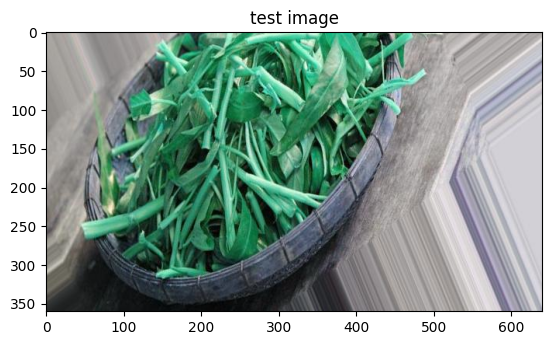

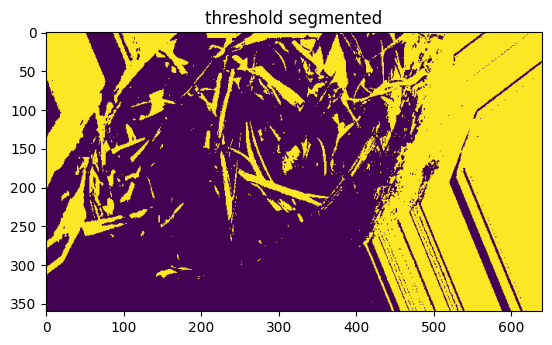

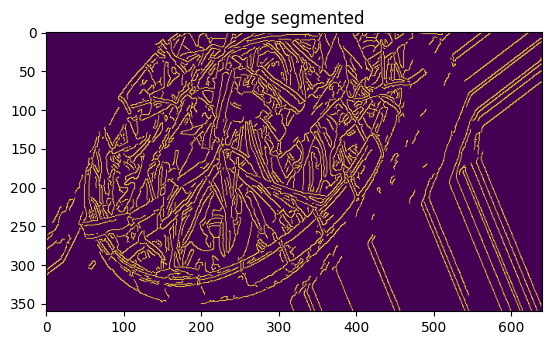

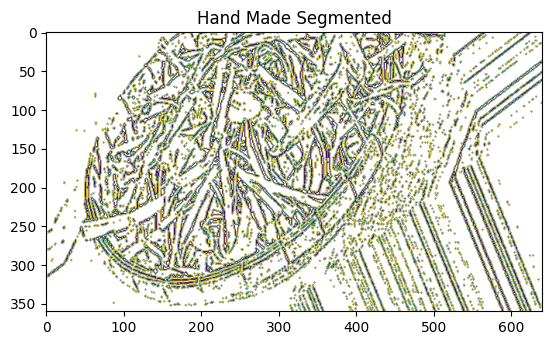

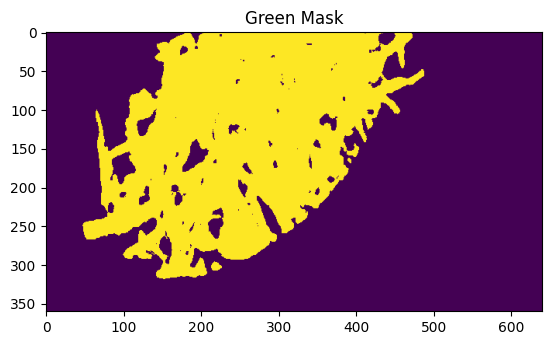

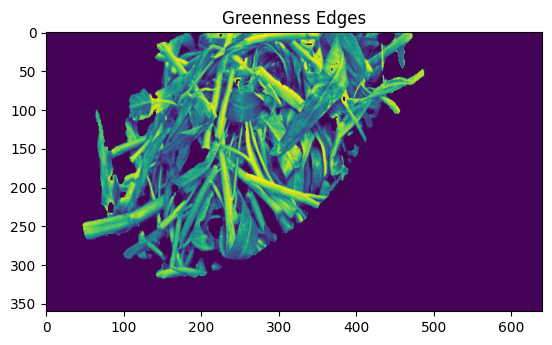

In [7]:
# Testing some of the segmentation code
# Will be removed later

test_image_path= os.path.join(PROJECT_MAP.dataDirectory, 'test.jpg')

test_image= DataProcessing.loadImage(test_image_path)
DataProcessing.displayImage(test_image, "test image")

segmented= DataProcessing.thresholdSegmentation(test_image, 150)
DataProcessing.displayImage(segmented, "threshold segmented")

edge_segmented= DataProcessing.edgeSegmentation(test_image, threshold=50)
DataProcessing.displayImage(edge_segmented, "edge segmented")

h_segmented= DataProcessing.handMadeSegmentation(test_image, 110)
DataProcessing.displayImage(h_segmented, "Hand Made Segmented")

#shows what mask output looks like
green_mask= DataProcessing.getGreennessMask(test_image)
DataProcessing.displayImage(green_mask, "Green Mask")

#shows what edges with CLAHE after greenness mask will look like
greenness_edges = DataProcessing.getEdgesFromGreenness(test_image)
DataProcessing.displayImage(greenness_edges, "Greenness Edges")


In [3]:
training_data, val_data, testing_data, classes = DataProcessing.loadAllDatasets(PROJECT_MAP.dataDirectory)
print(f'Classes: {classes}')
print(f'Len Classes: {len(classes)}')

for image, label in training_data.take(10):
    print("Label:", label.numpy())
#Creating dual sets
train_dual = DataProcessing.create_dual_input_dataset(training_data, DataProcessing.getEdgesFromGreenness)
val_dual = DataProcessing.create_dual_input_dataset(val_data, DataProcessing.getEdgesFromGreenness)
test_dual = DataProcessing.create_dual_input_dataset(testing_data, DataProcessing.getEdgesFromGreenness)

for (inputs, label) in train_dual.take(1):
    print("Raw shape:", inputs[0].shape)
    print("Mask shape:", inputs[1].shape)
    print("Label shape:", label.shape)

Found 23972 files belonging to 30 classes.


I0000 00:00:1752604608.091433   71257 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 3030 files belonging to 30 classes.
Found 2998 files belonging to 30 classes.
Classes: ['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peper chili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweet potatoes', 'tobacco', 'waterapple', 'watermelon']
Len Classes: 30
Label: 6
Label: 20
Label: 20
Label: 22
Label: 6
Label: 18
Label: 15
Label: 4
Label: 20
Label: 23


2025-07-15 13:36:52.486155: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Raw shape: (32, 128, 128, 3)
Mask shape: (32, 128, 128, 1)
Label shape: (32,)


2025-07-15 13:36:52.847913: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
for image, label in training_data.take(10):
    print("Label:", label.numpy())

Label: 20
Label: 14
Label: 20
Label: 10
Label: 28
Label: 29
Label: 9
Label: 19
Label: 3
Label: 24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..137.22101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103.939..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103.939..119.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..139.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..148.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..126.32].
Clipping input da

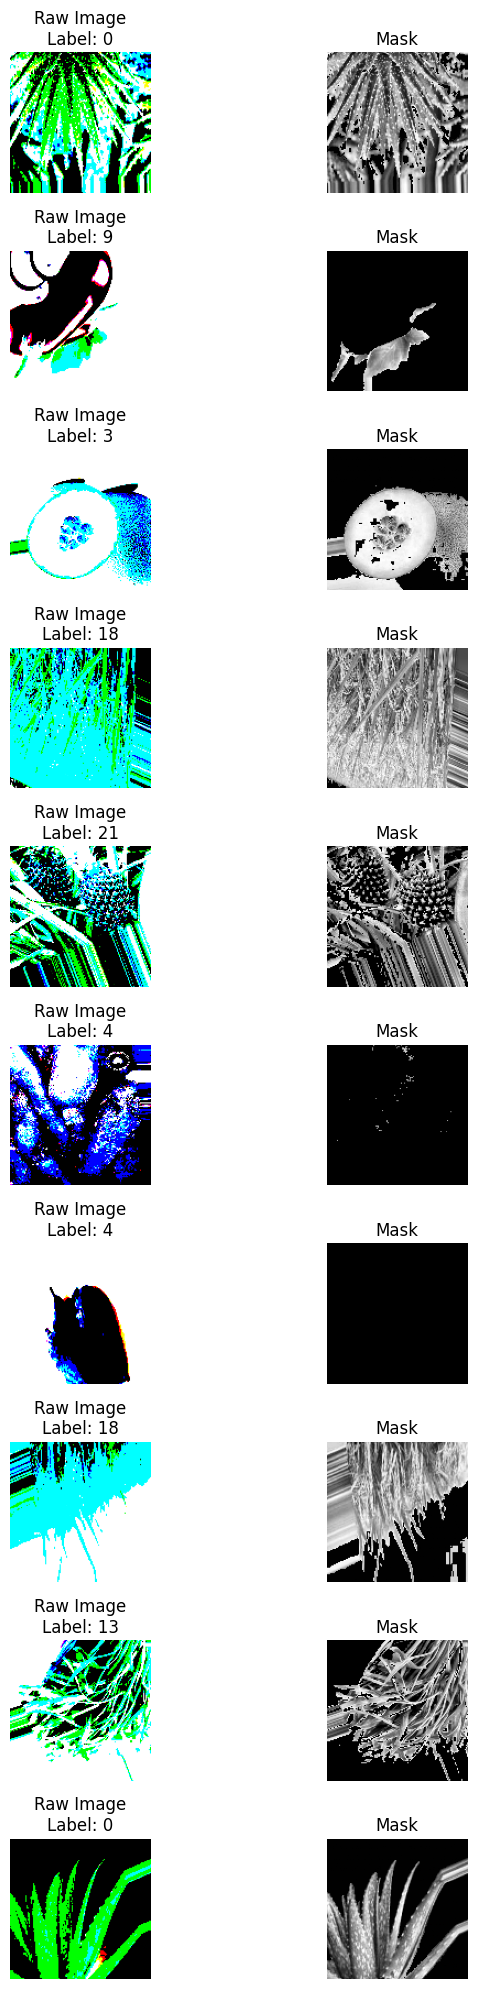

In [4]:
DataProcessing.displayProcessedImages(train_dual, 10)

In [5]:
dual_model = DualInputModel.DualInputModel(num_classes=30)
dual_model.buildModel()
dual_model.compileModel()
training_results= dual_model.trainModel(train_dual, val_data=val_dual, epochs=10) 
dual_model.testModel(test_dual)

Model compiled


I0000 00:00:1752604630.780448   71471 service.cc:152] XLA service 0x761948003850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752604630.780524   71471 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-07-15 13:37:11.016848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752604631.671806   71471 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-15 13:37:13.042634: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1615', 188 bytes spill stores, 188 bytes spill loads

2025-07-15 13:37:14.891301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

  1/750 ━━━━━━━━━━━━━━━━━━━━ 3:28:50 17s/step - accuracy: 0.0000e+00 - loss: 12.2083

I0000 00:00:1752604644.893773   71471 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3842 - loss: 2.4509

2025-07-15 13:38:33.323953: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1615', 8 bytes spill stores, 8 bytes spill loads

2025-07-15 13:38:34.066323: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1615', 104 bytes spill stores, 104 bytes spill loads

2025-07-15 13:38:34.566075: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1608', 8 bytes spill stores, 8 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3844 - loss: 2.4497

2025-07-15 13:38:53.861172: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_348', 200 bytes spill stores, 200 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 111s 126ms/step - accuracy: 0.3847 - loss: 2.4486 - val_accuracy: 0.7528 - val_loss: 0.7775
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step
Test Accuracy: 0.7508338892595063
              precision    recall  f1-score   support

           0       0.57      0.86      0.69       100
           1       0.84      0.89      0.86       100
           2       0.61      0.80      0.69       100
           3       0.50      0.77      0.60       100
           4       0.92      0.77      0.84       100
           5       0.73      0.55      0.63       100
           6       0.91      0.84      0.88       100
           7       0.70      0.92      0.79        99
           8       0.88      0.68      0.77       100
           9       0.72      0.90      0.80       100
          10       0.81      0.57      0.67       100
          11       0.65      0.77      0.70       100
          12       0.82      0.72      0.77       100
          13       0.69      0.62      0.65    

array([[8.8416618e-01, 5.3911080e-04, 6.7622452e-03, ..., 9.8045580e-03,
        1.1007404e-02, 4.9500144e-04],
       [7.8994471e-01, 1.8753582e-05, 4.0616398e-03, ..., 4.1352464e-03,
        1.6483229e-04, 8.6340951e-05],
       [8.3847189e-01, 5.3354813e-04, 2.6503450e-03, ..., 3.0088281e-02,
        1.3283984e-03, 1.6667730e-03],
       ...,
       [2.9780690e-08, 8.5291909e-08, 1.4509598e-07, ..., 2.0080481e-05,
        8.4317969e-07, 9.9852210e-01],
       [1.9719651e-05, 2.1632090e-06, 1.5256225e-05, ..., 2.5361715e-05,
        4.8318659e-03, 9.7343123e-01],
       [1.8954644e-02, 6.6108732e-03, 1.2463071e-02, ..., 1.4287958e-02,
        2.0527085e-02, 3.2809001e-01]], dtype=float32)